In this notebook, we will discuss some common practices that we skipped in the previous notebooks. These common practices will help us to train a model that generalize well, that is perform well on the new data that we want to predict. 

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

%matplotlib inline

## Classification Example

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

In [3]:
#get the dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split the dataset into a training and a testing set
# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y,
 test_size=0.25, random_state=33)
print(X_train.shape, y_train.shape)

(112, 4) (112,)


Let's standardize the input features

In [4]:
# Standardize the features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
#Using svm
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.94736842105263153

## Pipeline

We can use [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to chain all the operations into a simple pipeline:

In [6]:
from sklearn.pipeline import Pipeline

estimators = []
estimators.append(('standardize', preprocessing.StandardScaler()))
estimators.append(('svm', SVC()))
pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.94736842105263153

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.
However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.
A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:
A model is trained using k-1 of the folds as training data;
the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.


## Computing cross-validated metrics

The simplest way to use cross-validation is to call the cross_val_score helper function on the estimator and the dataset.

In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X, y, cv=5)
scores 

array([ 0.96666667,  0.96666667,  0.96666667,  0.93333333,  1.        ])

The mean score and the 95% confidence interval of the score estimate are hence given by:

In [8]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.97 (+/- 0.02)


It is also possible to use other cross validation strategies by passing a cross validation iterator instead, for instance:

In [9]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)

In [10]:
cross_val_score(pipe, iris.data, iris.target, cv=cv)

array([ 0.97777778,  0.93333333,  0.95555556])

## Using cross-validation choose parameters

For example, if we want to test different value of C vlaues for the SVM, we can run the following code and decide the best parameter. We can have a look of all the parameters we used in our pipeline by using get_params function. 

In [11]:
pipe.get_params()

{'standardize': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'steps': [('standardize',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False))],
 'svm': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'svm__C': 1.0,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': None,
 'svm__degree': 3,
 'svm__gamma': 'auto',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probability': False,
 'svm__random_state

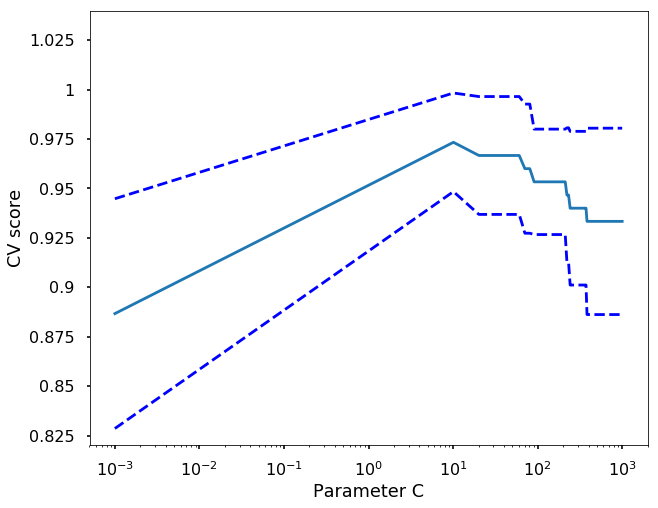

In [12]:
C_s = np.linspace(0.001, 1000, 100)

scores = list()
scores_std = list()
for C in C_s:
    pipe.set_params(svm__C = C)
    this_scores = cross_val_score(pipe, X, y, n_jobs=1, cv = 5)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
plt.figure(1, figsize=(10, 8))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0.82, 1.04)
plt.show()

Alternatively, we can use the [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to do the same thing:

In [13]:
from sklearn.model_selection import GridSearchCV

params = dict(svm__C=np.linspace(0.001, 1000, 100))

grid_search = GridSearchCV(estimator=pipe, param_grid=params,n_jobs=-1, cv=5)

grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__C': array([  1.00000e-03,   1.01020e+01, ...,   9.89899e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [14]:
grid_search.best_score_ 

0.97333333333333338

In [15]:
grid_search.best_params_

{'svm__C': 10.102}

In [16]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.0054081 ,  0.00385337,  0.00438766,  0.0025423 ,  0.0013309 ,
         0.00149269,  0.00122428,  0.00121813,  0.00158877,  0.00125127,
         0.00155072,  0.00122395,  0.00148811,  0.00145206,  0.00123606,
         0.00174541,  0.00124793,  0.00185738,  0.00130386,  0.00125442,
         0.00175381,  0.0012711 ,  0.00161991,  0.00161319,  0.00190425,
         0.00185299,  0.00129418,  0.0020009 ,  0.00197239,  0.00131168,
         0.0017972 ,  0.00131526,  0.00161352,  0.00135908,  0.00130587,
         0.0016376 ,  0.00133576,  0.00178161,  0.00169873,  0.0014369 ,
         0.00196376,  0.00145526,  0.00184755,  0.00146751,  0.00175142,
         0.00185928,  0.00223985,  0.00256615,  0.00199561,  0.00189061,
         0.00137696,  0.00140543,  0.00171742,  0.00136447,  0.00166564,
         0.00184011,  0.00254135,  0.00242219,  0.00137534,  0.00187426,
         0.00149875,  0.00218029,  0.00222387,  0.00221672,  0.0025743 ,
         0.00234179,  0.00176487, 

## Exercise

Using the grid_search.cv_results_ from the GridSearchCV, plot the same figure as above which showing the parameter C vs. CV score. 

In [17]:
# Do the plotting
plt.figure(1, figsize=(10, 8))
plt.clf()

## Your solution
C_s = 
scores = 
scores_std = 

plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0.82, 1.04)
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-143e34814304>, line 6)

In [ ]:
%load ../solutions/solution_05.py